In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import sklearn
import os

In [2]:
DATA_DIR = "./raw_data_2010_2023/"

In [3]:
def find_csv_files(folder_path, suffix=".csv"):
    """
    Find all CSV files in the given folder path.

    Args:
    - folder_path (str): Path to the folder where CSV files are located.
    - suffix (str): Suffix to filter files (default is '.csv').

    Returns:
    - list: List of CSV files with the given suffix.
    """
    csv_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(suffix):
                csv_files.append(os.path.join(root, file))
    return csv_files

In [4]:
def plot_top_n_categorical(data, column, n=None, figsize=(15, 5)):
    """
    Plot the distribution of the top N categories of a categorical variable.

    Args:
    - data (pandas DataFrame): DataFrame containing the categorical variable.
    - column (str): Name of the categorical variable column.
    - n (int or None): Number of top categories to plot. If None, plot all categories (default is None).
    - figsize (tuple): Width and height of the figure in inches (default is (10, 6)).

    Returns:
    - None (displays the plot).
    """
    if n is None:
        categories = data[column].value_counts().index
    else:
        categories = data[column].value_counts().nlargest(n).index
        
    data_filtered = data[data[column].isin(categories)]
    
    plt.figure(figsize=figsize)
    sns.countplot(data=data_filtered, x=column, order=categories)
    plt.title(f'Top {len(categories)} Categories of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()


In [5]:
all_data_files = find_csv_files(DATA_DIR, suffix="_cleaned.csv")

In [6]:
all_dfs = []
for f in all_data_files:
    all_dfs.append(pd.read_csv(f, parse_dates=["Date (MM/DD/YYYY)"]))

In [7]:
all_merged = pd.concat(all_dfs, ignore_index=True)

In [8]:
all_merged.head()

Carrier Code Date (MM/DD/YYYY)  Flight Number Tail Number Origin Airport  \
0           B6        2010-01-01             22      N608JB            JFK   
1           B6        2010-01-01             42      N586JB            JFK   
2           B6        2010-01-01             44      N586JB            JFK   
3           B6        2010-01-01             62      N284JB            JFK   
4           B6        2010-01-01            660      N653JB            MCO   

  Scheduled Arrival Time Actual Arrival Time  \
0                  00:01               02:41   
1                  11:52               13:05   
2                  08:55               09:11   
3                  16:23               16:21   
4                  20:48               20:49   

   Scheduled Elapsed Time (Minutes)  Actual Elapsed Time (Minutes)  \
0                                76                             72   
1                                71                             78   
2                                75                             60   
3                                84                             60   
4                               158                            148   

   Arrival Delay (Minutes) Wheels-on Time  Taxi-In time (Minutes)  \
0                      160          02:37                       4   
1                       73          12:59                       6   
2                       16          09:09                       2   
3                       -2          16:17                       4   
4                        1          20:47                       2   

   Delay Carrier (Minutes)  Delay Weather (Minutes)  \
0                      160                        0   
1                       66                        0   
2                       16                        0   
3                        0                        0   
4                        0                        0   

   Delay National Aviation System (Minutes)  Delay Security (Minutes)  \
0                                         0                         0   
1                                         7                         0   
2                                         0                         0   
3                                         0                         0   
4                                         0                         0   

   Delay Late Aircraft Arrival (Minutes)  
0                                      0  
1                                      0  
2                                      0  
3                                      0  
4                                      0

In [9]:
sorted_all_merged = all_merged.sort_values(by=['Date (MM/DD/YYYY)', 'Scheduled Arrival Time']).reset_index(drop=True)

In [10]:
sorted_all_merged = sorted_all_merged.drop_duplicates().reset_index(drop=True)

In [57]:
sorted_all_merged.shape

(113675, 17)

# CARRIER CODE

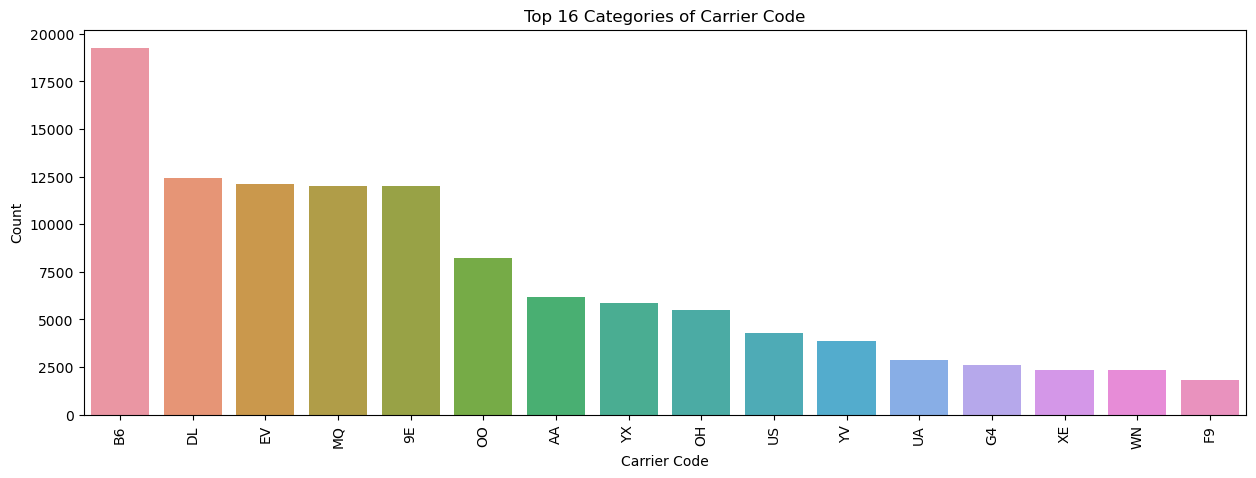

In [11]:
plot_top_n_categorical(sorted_all_merged, "Carrier Code")

# FLIGHT NUMBER

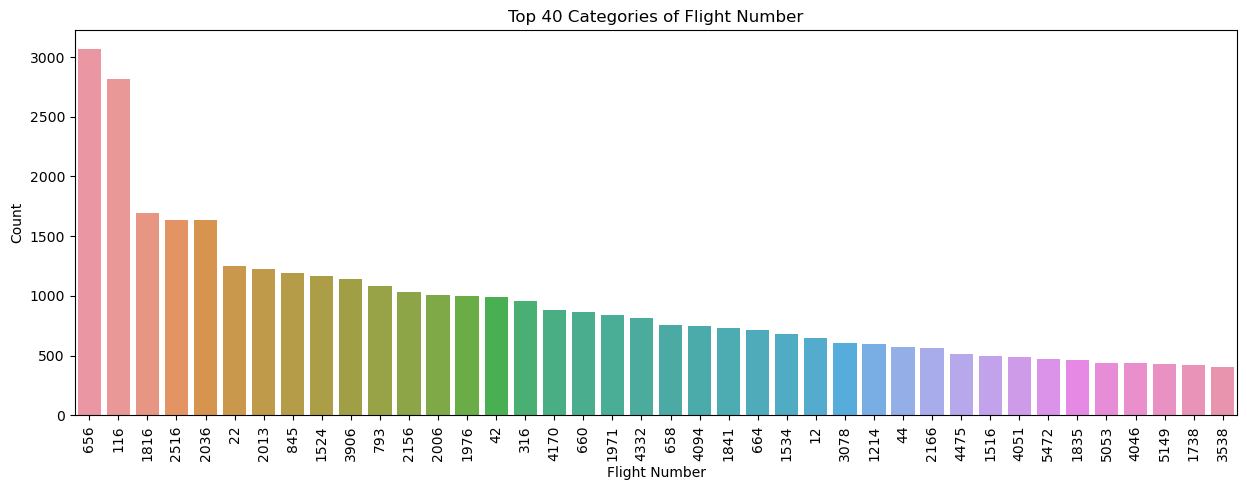

In [12]:
plot_top_n_categorical(sorted_all_merged, "Flight Number", 40)

# TAIL NUMBER

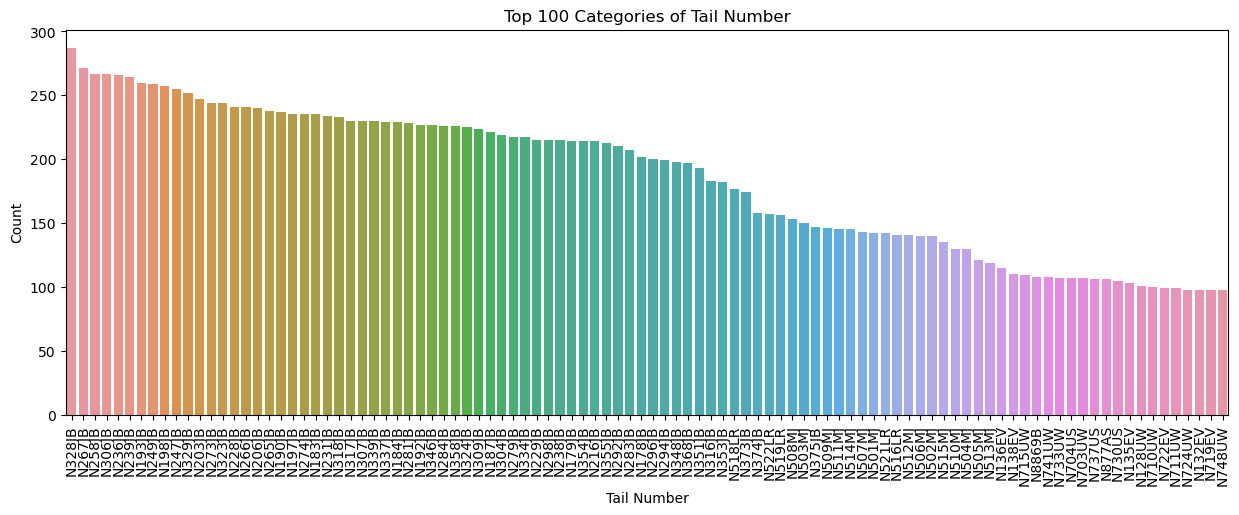

In [13]:
plot_top_n_categorical(sorted_all_merged, 'Tail Number', 100)

# ORIGIN AIRPORT

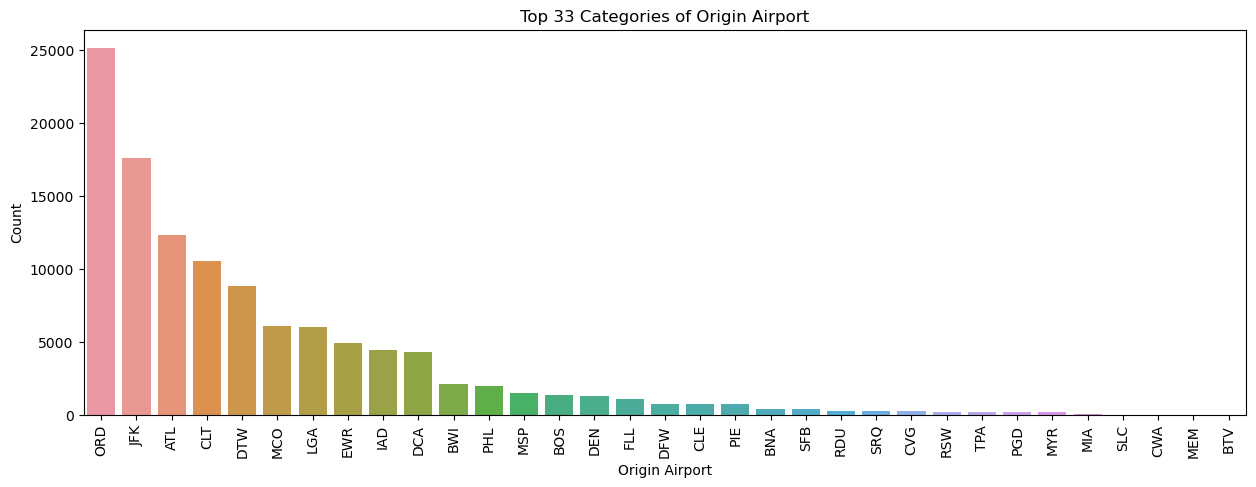

In [14]:
plot_top_n_categorical(sorted_all_merged, 'Origin Airport')

# COLUMNS

In [15]:
sorted_all_merged.columns

Index(['Carrier Code', 'Date (MM/DD/YYYY)', 'Flight Number', 'Tail Number',
       'Origin Airport', 'Scheduled Arrival Time', 'Actual Arrival Time',
       'Scheduled Elapsed Time (Minutes)', 'Actual Elapsed Time (Minutes)',
       'Arrival Delay (Minutes)', 'Wheels-on Time', 'Taxi-In time (Minutes)',
       'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)',
       'Delay Late Aircraft Arrival (Minutes)'],
      dtype='object')

In [16]:
to_drop = ['Wheels-on Time', 'Taxi-In time (Minutes)',
       'Delay Carrier (Minutes)', 'Delay Weather (Minutes)',
       'Delay National Aviation System (Minutes)', 'Delay Security (Minutes)',
       'Delay Late Aircraft Arrival (Minutes)']

In [17]:
def date_to_season(date):
    """
    Determine the season for a given date without considering the year.

    Parameters:
    date (Timestamp): The date.

    Returns:
    str: The season corresponding to the given date.
    """
    # Define fixed date ranges for each season
    seasons = {
        'winter': ((1, 1), (3, 20)),
        'spring': ((3, 21), (6, 20)),
        'summer': ((6, 21), (9, 22)),
        'autumn': ((9, 23), (12, 20)),
        'winter': ((12, 21), (12, 31)),
        'winter': ((1, 1), (1, 31))
    }

    # Get month and day from the date
    month = date.month
    day = date.day
    print(date.year, date.month, date.day)
    # Determine the season based on the month and day
    for season, (start_md, end_md) in seasons.items():
        if start_md <= (month, day) <= end_md:
            return season

In [18]:
def create_categorical_column(df):
    """
    Create a categorical column in the DataFrame based on the range of a numeric column by iterating over each row.

    Parameters:
    df (DataFrame): The pandas DataFrame.
    numeric_column (str): The name of the numeric column.

    Returns:
    DataFrame: The DataFrame with the new categorical column.
    """
    numeric_column = 'Arrival Delay (Minutes)'
    categorical_values = []
    for index, row in df.iterrows():
        numeric_value = row[numeric_column]
        # Customize the conditions based on your requirement
        if abs(numeric_value) <= 5:
            categorical_values.append('ONTIME')
        elif numeric_value < -5:
            categorical_values.append('EARLY')
        elif numeric_value > 5:
            categorical_values.append('LATE')
        else:
            print("THIS SHOULDN't HAPPEN")
    df['FLIGHT_STATUS'] = categorical_values
    return df

In [19]:
processed = sorted_all_merged.drop(columns=to_drop)

In [20]:
processed = create_categorical_column(processed)

In [21]:
processed = processed.drop(columns=[ 'Actual Elapsed Time (Minutes)', 'Actual Arrival Time'])

In [22]:
def month_to_season(month):
    """
    Determine the season for a given month.

    Parameters:
    month (int): The month number (1-12).

    Returns:
    str: The season corresponding to the given month.
    """
    # Define mapping of months to seasons
    season_map = {
        1: 'winter',
        2: 'winter',
        3: 'spring',
        4: 'spring',
        5: 'spring',
        6: 'summer',
        7: 'summer',
        8: 'summer',
        9: 'autumn',
        10: 'autumn',
        11: 'autumn',
        12: 'winter'
    }
    
    return season_map.get(month, 'Unknown')

In [23]:
processed['month'] = processed['Date (MM/DD/YYYY)'].dt.month

In [24]:
processed['day'] = processed['Date (MM/DD/YYYY)'].dt.day

In [25]:
processed['season'] = processed['month'].apply(month_to_season)

In [26]:
# processed.to_csv("./INITIAL_PROCESSED_DATA_NUMERIC.csv", index=False)

# DATA PREP FOR 2nd Model

In [51]:
processed.sort_values(by=['Date (MM/DD/YYYY)', 'Scheduled Arrival Time'])

Carrier Code Date (MM/DD/YYYY)  Flight Number Tail Number  \
0                B6        2010-01-01             22      N608JB   
1                B6        2010-01-01             44      N586JB   
2                MQ        2010-01-01           4094      N610MQ   
3                9E        2010-01-01           3818      89289E   
4                B6        2010-01-01             42      N586JB   
...             ...               ...            ...         ...   
113670           DL        2023-12-31           1319      N371NW   
113671           WN        2023-12-31           1894      N8699A   
113672           AA        2023-12-31            421      N105UW   
113673           UA        2023-12-31            264      N437UA   
113674           UA        2023-12-31           1552      N69830   

       Origin Airport Scheduled Arrival Time  \
0                 JFK                  00:01   
1                 JFK                  08:55   
2                 ORD                  11:20   
3                 DTW                  11:44   
4                 JFK                  11:52   
...               ...                    ...   
113670            DTW                  22:38   
113671            BWI                  22:40   
113672            DFW                  22:57   
113673            DEN                  23:05   
113674            EWR                  23:09   

        Scheduled Elapsed Time (Minutes)  Arrival Delay (Minutes)  \
0                                     76                      160   
1                                     75                       16   
2                                    100                        4   
3                                     84                       22   
4                                     71                       73   
...                                  ...                      ...   
113670                                83                      -10   
113671                                70                       19   
113672                               181                       -5   
113673                               198                        5   
113674                                74                      -13   

       FLIGHT_STATUS  month  day  season  
0               LATE      1    1  winter  
1               LATE      1    1  winter  
2             ONTIME      1    1  winter  
3               LATE      1    1  winter  
4               LATE      1    1  winter  
...              ...    ...  ...     ...  
113670         EARLY     12   31  winter  
113671          LATE     12   31  winter  
113672        ONTIME     12   31  winter  
113673        ONTIME     12   31  winter  
113674         EARLY     12   31  winter  

[113675 rows x 12 columns]

In [72]:
def create_data_2nd_model_data(df, prev_status='ONTIME'):
    prevStatus = []
    for index, row in df.iterrows():
        prevStatus.append(prev_status)
        prev_status = row['FLIGHT_STATUS']
    df['PREV_STAT'] = pd.Series(prevStatus)
    return df

In [73]:
def create_data_2nd_model_data_ext(df, num_prev=3):
    extended_data = []
    for index, row in df.iterrows():
        for i in range(num_prev):
            if index - i - 1 >= 0:
                extended_row = row.copy()  # Create a copy of the current row
                extended_row['PREV_STAT'] = df.iloc[index - i - 1]['FLIGHT_STATUS']
                extended_data.append(extended_row)
            else:
                extended_row = row.copy()  # Create a copy of the current row
                extended_row['PREV_STAT'] = 'ONTIME'
                extended_data.append(extended_row)
    df_extended = pd.DataFrame(extended_data)
    return df_extended.reset_index(drop=True)


In [74]:
final_data = processed.drop(columns=['Arrival Delay (Minutes)'])

In [75]:
final_data.head()

Carrier Code Date (MM/DD/YYYY)  Flight Number Tail Number Origin Airport  \
0           B6        2010-01-01             22      N608JB            JFK   
1           B6        2010-01-01             44      N586JB            JFK   
2           MQ        2010-01-01           4094      N610MQ            ORD   
3           9E        2010-01-01           3818      89289E            DTW   
4           B6        2010-01-01             42      N586JB            JFK   

  Scheduled Arrival Time  Scheduled Elapsed Time (Minutes) FLIGHT_STATUS  \
0                  00:01                                76          LATE   
1                  08:55                                75          LATE   
2                  11:20                               100        ONTIME   
3                  11:44                                84          LATE   
4                  11:52                                71          LATE   

   month  day  season  
0      1    1  winter  
1      1    1  winter  
2      1    1  winter  
3      1    1  winter  
4      1    1  winter

In [77]:
# create_data_2nd_model_data(final_data).to_csv("1_HOP.csv", index=False)

In [78]:
# create_data_2nd_model_data_ext(final_data).to_csv("3_HOP.csv", index=False)